# CV - Image Classification Lab


## Basic Level
In this part, we will attempt a binary classification problem using a DNN and a CNN.

We will then proceed to change our network architectures to solve a multiclassification problem.

The dataset used consists of medical images of breast cancer using ultrasound scan.

The images are categorized into three classes, which are **normal**, **benign**, and **malignant**.

### Necessary imports

In [74]:
!pip install keras 
!pip install tensorflow

In [75]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import os.path
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical 
import random
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
from keras.layers import LeakyReLU
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, BatchNormalization, Conv2D
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.optimizers import Adam




In [76]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [77]:
folder = 'Dataset'
rs = 1
ts = 0.25

### Exercise 1
The directory above contains the dataset for this week's assignment (Assignment_Dataset). 

You'll find three folders within it, **normal** ,**malignant** and **benign**.
Load the images within the three folders, with the appropriate labels (the images within the folder **malignant** should be labelled with **malignant**, same goes for **benign** and **normal**).
One way to do this, is to load the images in one list, and load the labels (corresponding to the name of the folder you load the scans from) in another list.

Keep in mind that our dataset is relatively small, whereas standard image classification tasks often use datasets comprising tens of thousands of images.

### Exercise 1
The directory above contains the dataset for this week's assignment (Assignment_Dataset). 

You'll find three folders within it, **normal** ,**malignant** and **benign**.
Load the images within the three folders, with the appropriate labels (the images within the folder **malignant** should be labelled with **malignant**, same goes for **benign** and **normal**).
One way to do this, is to load the images in one list, and load the labels (corresponding to the name of the folder you load the scans from) in another list.

Keep in mind that our dataset is relatively small, whereas standard image classification tasks often use datasets comprising tens of thousands of images.

In [78]:
images = []
label = []

directories = ['normal', 'malignant', 'benign']

for dir_name in directories:
    folder_path = os.path.join(folder, dir_name)
    # For each file in the directory
    for file_name in tqdm(os.listdir(folder_path)):
        # Full path to the image
        file_path = os.path.join(folder_path, file_name)
        try:
            # Open the image and append to images list
            img = Image.open(file_path)
            images.append(img)
            label.append(dir_name)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

100%|██████████| 437/437 [00:00<00:00, 2888.82it/s]


In [79]:
print("In all folders, we have", len(images),
      "images", "and", len(label), "corresponding labels")

In all folders, we have 780 images and 780 corresponding labels


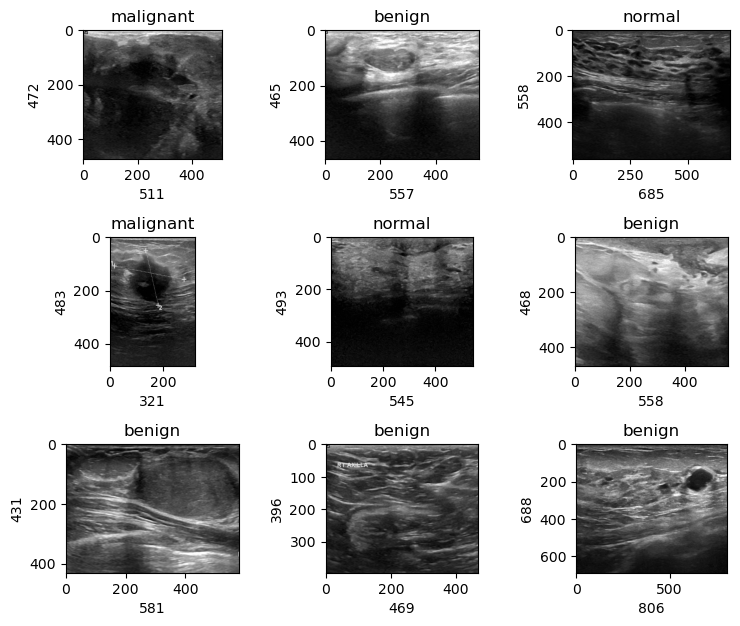

In [80]:
vis_images, vis_label = shuffle(images, label)
plt.figure(figsize=(8, 8))
for i in range(1, 10):
    plt.subplot(4, 3, i)
    plt.tight_layout()
    plt.imshow(vis_images[i-1])
    plt.title(vis_label[i-1])
    plt.xlabel(vis_images[i-1].size[0], fontsize=10)
    plt.ylabel(vis_images[i-1].size[1], fontsize=10)

### Exercise 2
Write a function **convert(dataset, target_mode)** that will take your list of images and convert them from their current mode RGB, to the target mode **L** (grayscale).

In [81]:
print("The current mode of the images in the dataset is", images[0].mode)

The current mode of the images in the dataset is RGB


In [82]:
def convert(dataset, mode):
    dataset = [img.convert(mode) for img in dataset]
    return dataset

In [83]:
images = convert(images, 'L')

In [84]:
print("Image mode is now", images[0].mode)

Image mode is now L


### Exercise 3
It turns out that the images in our dataset are not of the same size. 
Write a function **check_size(dataset)**, which inputs your dataset of images and returns True if all images are of the same size and False otherwise.

In [85]:
def check_size(dataset):
    first_img_size = dataset[0].size
    for img in dataset:
        if img.size != first_img_size:
            check = False
    check = True
    return check

In [86]:
print("All images are of the same size:", check_size(images))

All images are of the same size: True


### Exercise 4
Write a function **resize(dataset, size)**, to which you pass your dataset and a tuple (h, w). Your function should output the dataset with all the images in the same size.

In [87]:
def resize(dataset, size):
    resized_dataset = []
    for img in dataset:
        resized_img = img.resize(size)
        resized_dataset.append(resized_img)
    dataset = resized_dataset
    return dataset

In [88]:
resized_images = resize(images, (64, 64))

In [89]:
print("All images are of the same size:", check_size(images))

All images are of the same size: True


In [90]:
print(type(images[0]))

<class 'PIL.Image.Image'>


### Exercise 5
Recall that a model cannot be trained on an Image object, we need first to convert our dataset of images into a dataset of numpy arrays, in which every array is the representation of an image.

Write a function **to_npArray(dataset)**, which will input your images dataset and return the dataset with the images converted to numpy arrays.

In [91]:
def to_npArray(dataset):
    dataset = [np.array(img) for img in dataset]
    return dataset

In [92]:
np_images = to_npArray(resized_images)

In [93]:
np_images = np.array(np_images)

In [94]:
np_images.shape

(780, 64, 64)

#### You can see now that our dataset has 780 examples, each example is of the shape (h,w). In our case here (64,64). Feel free to resize your images to the values you see fit. Keep in mind that a higher size means more features, slower training, and a higher risk of overfitting.

### Exercise 6
Pixel values in our grayscale images might go up to 255, when calculating the sigmoid of such values (multiplied by their respective weights), we might end up with overflow issues.
One way to solve this problem is by feature scaling.
You can use sklearn's [MixMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to scale the features in your dataset. You can also implement your own scaler, by simply dividing all the values in your dataset by the max value.

In [95]:
print("Before scaling : Min={}, max={}".format(np_images.min(), np_images.max()))
np_images = np_images / 255.0
print("After scaling  : Min={}, max={}".format(np_images.min(), np_images.max()))


Before scaling : Min=0, max=255
After scaling  : Min=0.0, max=1.0


## Binary classification 
We'll start by doing a binary classification problem.

In later exercises, we will shift back to treating the multiclassification problem the dataset suggests.
### Exercise 7

We are now preparing our dataset for binary classification. While our dataset contains three classes - **benign**, **malignant**, and **normal** - our initial model will categorize the scans as either **0** (malignant) or **1** (either normal or benign). We'll formulate a 'y' vector where the '**malignant**' label is encoded as **0**, and the other labels are encoded as **1**.


In [96]:
y = [0 if label_name == 'malignant' else 1 for label_name in label]
y = np.array(y)
print(y[:10])

[1 1 1 1 1 1 1 1 1 1]


### Exercise 8

For this task, you'll employ **Keras** to construct your neural network. We've shown in the lecture how straightforward it is to design DNNs with Keras: all you need to do is outline your network's structure and let Keras do the heavy lifting.

The lecture's demonstration assumes that images have been flattened before they are fed into the Keras DNN. This means the dataset will have a shape like (ne, w, h). Given our dataset with **780 samples** and an image size of (64 , 64), when you flatten these images, they will reshape the dataset to (780, 4096).

Keras can also handle the flattening for you. So, you can supply the dataset in the shape (780, 64, 64) and Keras will take care of reshaping before starting the model's training.

a. Reshape your dataset to what Keras expects


In [97]:
np_images_flattened = np_images.reshape((780, 64*64))

In [98]:
np_images_flattened.shape

(780, 4096)

In [99]:
train_X, test_X, train_y, test_y = train_test_split(np_images_flattened, y, test_size=ts, shuffle=True, random_state=rs)

b. Create your model and compile it in the cell below

In [100]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(4096,)),
    Dense(32, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               524416    
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                                 
 dense_21 (Dense)            (None, 4)                 132       
                                                                 
 dense_22 (Dense)            (None, 1)                 5         
                                                                 
Total params: 528681 (2.02 MB)
Trainable params: 528681 (2.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


c. Fit the model to the data below

In [102]:
batch_size = 32
epochs = 200
history = model.fit(train_X, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_X, test_y),
                    verbose=1)

Epoch 1/200
19/19 [==============================] - 2s 35ms/step - loss: 0.6228 - accuracy: 0.6991 - val_loss: 0.5513 - val_accuracy: 0.7538
Epoch 2/200
19/19 [==============================] - 0s 17ms/step - loss: 0.5804 - accuracy: 0.7231 - val_loss: 0.5326 - val_accuracy: 0.7538
Epoch 3/200
19/19 [==============================] - 0s 15ms/step - loss: 0.5428 - accuracy: 0.7231 - val_loss: 0.5309 - val_accuracy: 0.7538
Epoch 4/200
19/19 [==============================] - 0s 17ms/step - loss: 0.5427 - accuracy: 0.7231 - val_loss: 0.5088 - val_accuracy: 0.7538
Epoch 5/200
19/19 [==============================] - 0s 19ms/step - loss: 0.5196 - accuracy: 0.7231 - val_loss: 0.5131 - val_accuracy: 0.7538
Epoch 6/200
19/19 [==============================] - 0s 15ms/step - loss: 0.5113 - accuracy: 0.7231 - val_loss: 0.4968 - val_accuracy: 0.7538
Epoch 7/200
19/19 [==============================] - 0s 16ms/step - loss: 0.5022 - accuracy: 0.7231 - val_loss: 0.4929 - val_accuracy: 0.7538
Epoch 

19/19 [==============================] - 0s 13ms/step - loss: 0.1727 - accuracy: 0.9385 - val_loss: 0.4643 - val_accuracy: 0.8154
Epoch 59/200
19/19 [==============================] - 0s 16ms/step - loss: 0.1929 - accuracy: 0.9282 - val_loss: 0.4760 - val_accuracy: 0.8462
Epoch 60/200
19/19 [==============================] - 0s 18ms/step - loss: 0.1654 - accuracy: 0.9436 - val_loss: 0.4671 - val_accuracy: 0.8410
Epoch 61/200
19/19 [==============================] - 0s 17ms/step - loss: 0.1566 - accuracy: 0.9538 - val_loss: 0.4700 - val_accuracy: 0.8359
Epoch 62/200
19/19 [==============================] - 0s 16ms/step - loss: 0.1556 - accuracy: 0.9573 - val_loss: 0.4775 - val_accuracy: 0.8462
Epoch 63/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1606 - accuracy: 0.9402 - val_loss: 0.5376 - val_accuracy: 0.7692
Epoch 64/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1447 - accuracy: 0.9641 - val_loss: 0.4736 - val_accuracy: 0.8513
Epoch 65/200

19/19 [==============================] - 0s 13ms/step - loss: 0.0473 - accuracy: 0.9949 - val_loss: 0.6376 - val_accuracy: 0.7949
Epoch 116/200
19/19 [==============================] - 0s 14ms/step - loss: 0.0440 - accuracy: 0.9949 - val_loss: 0.6236 - val_accuracy: 0.8154
Epoch 117/200
19/19 [==============================] - 0s 18ms/step - loss: 0.0405 - accuracy: 0.9966 - val_loss: 0.6277 - val_accuracy: 0.8154
Epoch 118/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0415 - accuracy: 0.9949 - val_loss: 0.6582 - val_accuracy: 0.7744
Epoch 119/200
19/19 [==============================] - 1s 29ms/step - loss: 0.0394 - accuracy: 0.9983 - val_loss: 0.6292 - val_accuracy: 0.8205
Epoch 120/200
19/19 [==============================] - 0s 18ms/step - loss: 0.0421 - accuracy: 0.9966 - val_loss: 0.6641 - val_accuracy: 0.7846
Epoch 121/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0373 - accuracy: 0.9966 - val_loss: 0.6567 - val_accuracy: 0.7949
Epoch 

Epoch 172/200
19/19 [==============================] - 0s 14ms/step - loss: 0.0256 - accuracy: 0.9966 - val_loss: 0.7748 - val_accuracy: 0.7897
Epoch 173/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0173 - accuracy: 0.9966 - val_loss: 0.8168 - val_accuracy: 0.7692
Epoch 174/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0204 - accuracy: 0.9932 - val_loss: 0.8083 - val_accuracy: 0.7795
Epoch 175/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0231 - accuracy: 0.9966 - val_loss: 0.7884 - val_accuracy: 0.8000
Epoch 176/200
19/19 [==============================] - 0s 14ms/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 0.7599 - val_accuracy: 0.8359
Epoch 177/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.8012 - val_accuracy: 0.7846
Epoch 178/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0169 - accuracy: 0.9932 - val_loss: 0.7659 - val_accuracy:

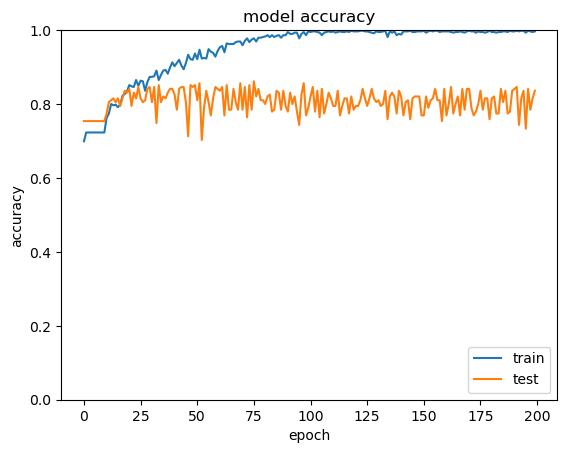

In [103]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.ylim(0, 1)
plt.show()

d. Print the accuracy of your model on the train and test set

In [104]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
print(f"Accuracy of the model on the train set is {train_accuracy * 100:.2f} %")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Accuracy of the model on the test set is {test_accuracy * 100:.2f} %")


Accuracy of the model on the train set is 99.66 %
Accuracy of the model on the test set is 83.59 %


e. Update the confusion matrix below to check how good your model has done on the data.

7/7 [==============================] - 0s 3ms/step


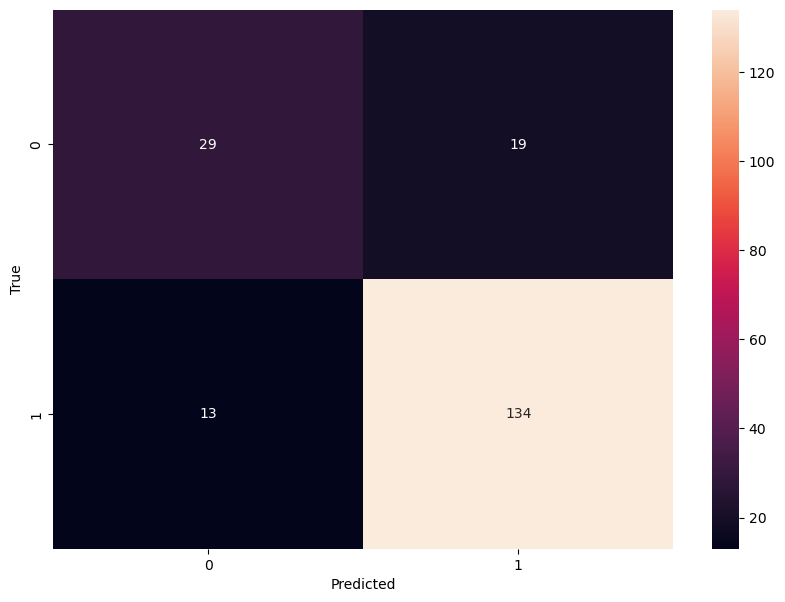

In [105]:
predictions = model.predict(test_X)
predicted_labels = (predictions > 0.5).astype("int32")
cm = confusion_matrix(test_y, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Exercise 9
For this exercise, we use a CNN and compare its performance with our previous results. You can choose any CNN architecture. However, be aware that adding many layers or filters will increase the number of parameters, which might extend the training time.

In [106]:
train_X, test_X, train_y, test_y = train_test_split(np_images, y, test_size=ts, shuffle=True, random_state=rs)

a. Create and compile your model architecture below

In [107]:
model = Sequential()

model.add(Conv2D(filters=1, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=2, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=1, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [108]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 1)         10        
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 8)         80        
                                                                 
 conv2d_10 (Conv2D)          (None, 58, 58, 2)         146       
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 1)         19        
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_23 (Dense)            (None, 64)                200768    
                                                                 
 dense_24 (Dense)            (None, 4)                

b. Fit your CNN to the data

In [109]:
batch_size = 32
epochs = 100
history = model.fit(train_X, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_X, test_y),
                    verbose=1)

Epoch 1/100
19/19 [==============================] - 5s 102ms/step - loss: 0.6110 - accuracy: 0.7026 - val_loss: 0.5570 - val_accuracy: 0.7538
Epoch 2/100
19/19 [==============================] - 2s 81ms/step - loss: 0.5665 - accuracy: 0.7231 - val_loss: 0.5456 - val_accuracy: 0.7538
Epoch 3/100
19/19 [==============================] - 2s 86ms/step - loss: 0.5374 - accuracy: 0.7231 - val_loss: 0.5201 - val_accuracy: 0.7538
Epoch 4/100
19/19 [==============================] - 2s 87ms/step - loss: 0.5089 - accuracy: 0.7231 - val_loss: 0.4874 - val_accuracy: 0.7538
Epoch 5/100
19/19 [==============================] - 2s 109ms/step - loss: 0.4728 - accuracy: 0.7231 - val_loss: 0.4812 - val_accuracy: 0.7538
Epoch 6/100
19/19 [==============================] - 2s 100ms/step - loss: 0.4433 - accuracy: 0.7778 - val_loss: 0.4693 - val_accuracy: 0.7692
Epoch 7/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4038 - accuracy: 0.8154 - val_loss: 0.4879 - val_accuracy: 0.7692
Ep

19/19 [==============================] - 1s 78ms/step - loss: 0.1052 - accuracy: 0.9966 - val_loss: 1.0638 - val_accuracy: 0.8205
Epoch 59/100
19/19 [==============================] - 2s 92ms/step - loss: 0.1018 - accuracy: 0.9949 - val_loss: 1.0063 - val_accuracy: 0.7897
Epoch 60/100
19/19 [==============================] - 2s 101ms/step - loss: 0.0996 - accuracy: 0.9949 - val_loss: 1.2734 - val_accuracy: 0.8359
Epoch 61/100
19/19 [==============================] - 2s 104ms/step - loss: 0.0978 - accuracy: 0.9966 - val_loss: 1.0383 - val_accuracy: 0.8000
Epoch 62/100
19/19 [==============================] - 2s 102ms/step - loss: 0.0980 - accuracy: 0.9966 - val_loss: 1.4768 - val_accuracy: 0.8256
Epoch 63/100
19/19 [==============================] - 2s 100ms/step - loss: 0.0970 - accuracy: 0.9966 - val_loss: 1.2494 - val_accuracy: 0.8308
Epoch 64/100
19/19 [==============================] - 2s 94ms/step - loss: 0.1012 - accuracy: 0.9932 - val_loss: 1.1979 - val_accuracy: 0.8256
Epoch 65

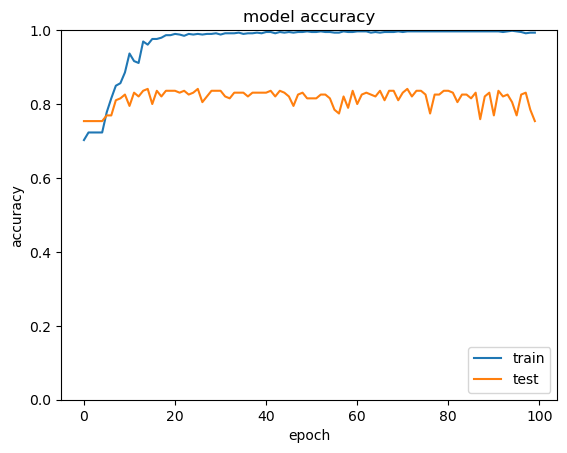

In [110]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

c. Print your model's accuracy on the test and train sets

In [111]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
print(f"Accuracy of the model on the train set is {train_accuracy * 100:.2f} %")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Accuracy of the model on the test set is {test_accuracy * 100:.2f} %")


Accuracy of the model on the train set is 99.66 %
Accuracy of the model on the test set is 75.38 %


d. Create a confusion matrix to inspect the model's output

7/7 [==============================] - 0s 27ms/step


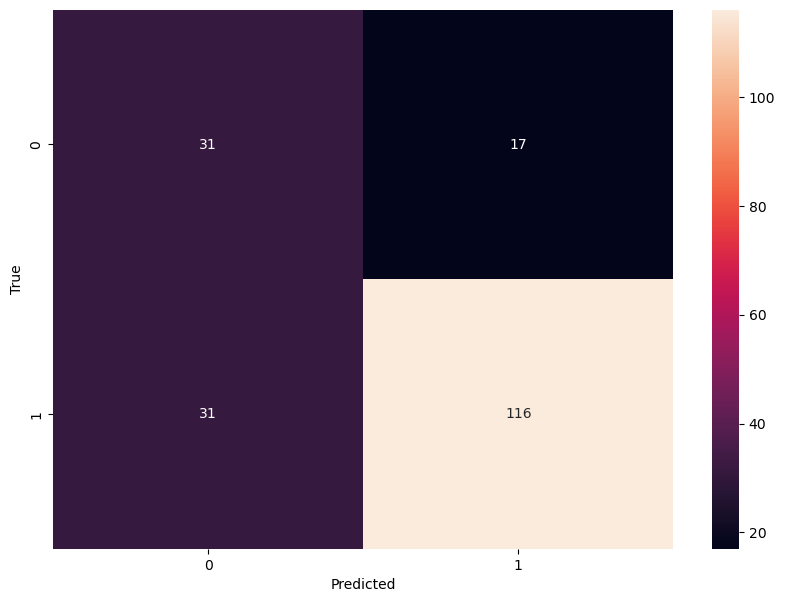

In [112]:
predictions = model.predict(test_X)
predicted_labels = (predictions > 0.5).astype("int32")
cm = confusion_matrix(test_y, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Multiclassification
Let's now shift back to the main challenge in the dataset and build models that can distinguish the three classes, and not just segregate the **malignant** scans from the other scans.

Our first task is to encode our **y** vector properly. 
Keep also in mind that the **sigmoid** activation is not the right choice for the output layer, and that the number of neurons of the output layer needs to be equal to the number of expected classes.

### Exercise 10
Create a **y** matrix for your labels. The **y** matrix is of shape **(ne, nc)**. 

With **ne** meaning number of examples and **nc** meaning number of possible classes.

Refer to keras' to_categorical() function to create your ground truth matrix.

In [113]:
y = [0 if label_name == 'malignant' else 1 if label_name == 'benign' else 2 for label_name in label]
y = np.array(y)
print(y.shape)
y = to_categorical(y, num_classes=3)

(780,)


In [114]:
y.shape

(780, 3)

### Exercise 11


In [115]:
train_X, test_X, train_y, test_y = train_test_split(np_images_flattened, y, test_size=ts, shuffle=True, random_state=rs)

a. You can now create another DNN to classify your scans according to their labels.

In [116]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(4096,)),
    Dense(32, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               524416    
                                                                 
 dense_27 (Dense)            (None, 32)                4128      
                                                                 
 dense_28 (Dense)            (None, 4)                 132       
                                                                 
 dense_29 (Dense)            (None, 3)                 15        
                                                                 
Total params: 528691 (2.02 MB)
Trainable params: 528691 (2.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


b. Train your model below

In [118]:
batch_size = 32
epochs = 200
history = model.fit(train_X, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_X, test_y),
                    verbose=1)

Epoch 1/200
19/19 [==============================] - 2s 35ms/step - loss: 0.9865 - accuracy: 0.5487 - val_loss: 0.9915 - val_accuracy: 0.5590
Epoch 2/200
19/19 [==============================] - 0s 20ms/step - loss: 0.9688 - accuracy: 0.5607 - val_loss: 0.9825 - val_accuracy: 0.5590
Epoch 3/200
19/19 [==============================] - 0s 16ms/step - loss: 0.9615 - accuracy: 0.5607 - val_loss: 0.9717 - val_accuracy: 0.5590
Epoch 4/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9591 - accuracy: 0.5607 - val_loss: 0.9677 - val_accuracy: 0.5590
Epoch 5/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9522 - accuracy: 0.5607 - val_loss: 0.9685 - val_accuracy: 0.5590
Epoch 6/200
19/19 [==============================] - 0s 16ms/step - loss: 0.9426 - accuracy: 0.5607 - val_loss: 0.9632 - val_accuracy: 0.5590
Epoch 7/200
19/19 [==============================] - 0s 16ms/step - loss: 0.9329 - accuracy: 0.5607 - val_loss: 0.9572 - val_accuracy: 0.5590
Epoch 

19/19 [==============================] - 0s 17ms/step - loss: 0.6486 - accuracy: 0.6974 - val_loss: 0.9604 - val_accuracy: 0.5949
Epoch 59/200
19/19 [==============================] - 0s 16ms/step - loss: 0.6812 - accuracy: 0.6701 - val_loss: 0.9251 - val_accuracy: 0.5744
Epoch 60/200
19/19 [==============================] - 0s 17ms/step - loss: 0.6291 - accuracy: 0.7214 - val_loss: 0.9339 - val_accuracy: 0.5795
Epoch 61/200
19/19 [==============================] - 0s 23ms/step - loss: 0.6143 - accuracy: 0.7060 - val_loss: 0.9344 - val_accuracy: 0.5538
Epoch 62/200
19/19 [==============================] - 0s 16ms/step - loss: 0.5935 - accuracy: 0.7282 - val_loss: 0.9461 - val_accuracy: 0.5744
Epoch 63/200
19/19 [==============================] - 0s 16ms/step - loss: 0.5839 - accuracy: 0.7299 - val_loss: 1.0064 - val_accuracy: 0.6000
Epoch 64/200
19/19 [==============================] - 0s 17ms/step - loss: 0.5746 - accuracy: 0.7197 - val_loss: 0.9271 - val_accuracy: 0.5692
Epoch 65/200

19/19 [==============================] - 0s 16ms/step - loss: 0.2157 - accuracy: 0.9641 - val_loss: 0.9808 - val_accuracy: 0.6462
Epoch 116/200
19/19 [==============================] - 0s 16ms/step - loss: 0.2230 - accuracy: 0.9521 - val_loss: 0.9628 - val_accuracy: 0.6513
Epoch 117/200
19/19 [==============================] - 0s 17ms/step - loss: 0.2080 - accuracy: 0.9607 - val_loss: 0.9656 - val_accuracy: 0.6410
Epoch 118/200
19/19 [==============================] - 0s 17ms/step - loss: 0.1936 - accuracy: 0.9624 - val_loss: 0.9797 - val_accuracy: 0.6308
Epoch 119/200
19/19 [==============================] - 0s 16ms/step - loss: 0.1943 - accuracy: 0.9624 - val_loss: 0.9765 - val_accuracy: 0.6359
Epoch 120/200
19/19 [==============================] - 0s 16ms/step - loss: 0.1990 - accuracy: 0.9675 - val_loss: 0.9887 - val_accuracy: 0.6359
Epoch 121/200
19/19 [==============================] - 0s 16ms/step - loss: 0.1908 - accuracy: 0.9590 - val_loss: 0.9567 - val_accuracy: 0.6513
Epoch 

Epoch 172/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0677 - accuracy: 0.9863 - val_loss: 1.1439 - val_accuracy: 0.6769
Epoch 173/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0669 - accuracy: 0.9846 - val_loss: 1.1681 - val_accuracy: 0.6667
Epoch 174/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0653 - accuracy: 0.9880 - val_loss: 1.1790 - val_accuracy: 0.6564
Epoch 175/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0802 - accuracy: 0.9846 - val_loss: 1.2491 - val_accuracy: 0.6615
Epoch 176/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0624 - accuracy: 0.9897 - val_loss: 1.2407 - val_accuracy: 0.6513
Epoch 177/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0616 - accuracy: 0.9863 - val_loss: 1.2565 - val_accuracy: 0.6205
Epoch 178/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0623 - accuracy: 0.9863 - val_loss: 1.2445 - val_accuracy:

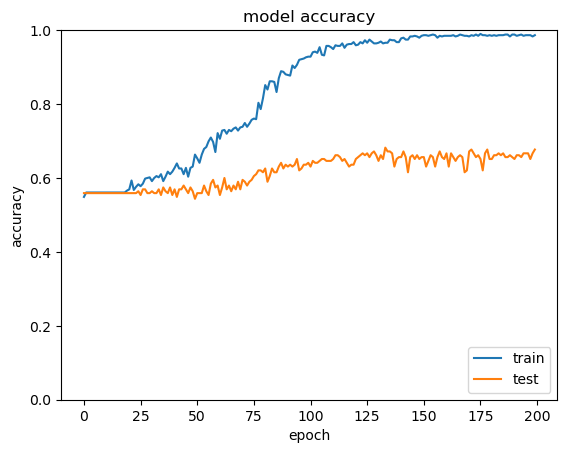

In [119]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

c. Print your model's accuracy on the test and train sets

In [120]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
print(f"Accuracy of the model on the train set is {train_accuracy * 100:.2f} %")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Accuracy of the model on the test set is {test_accuracy * 100:.2f} %")


Accuracy of the model on the train set is 98.63 %
Accuracy of the model on the test set is 67.69 %


d. Create a confusion matrix to inspect the model's output

7/7 [==============================] - 0s 2ms/step


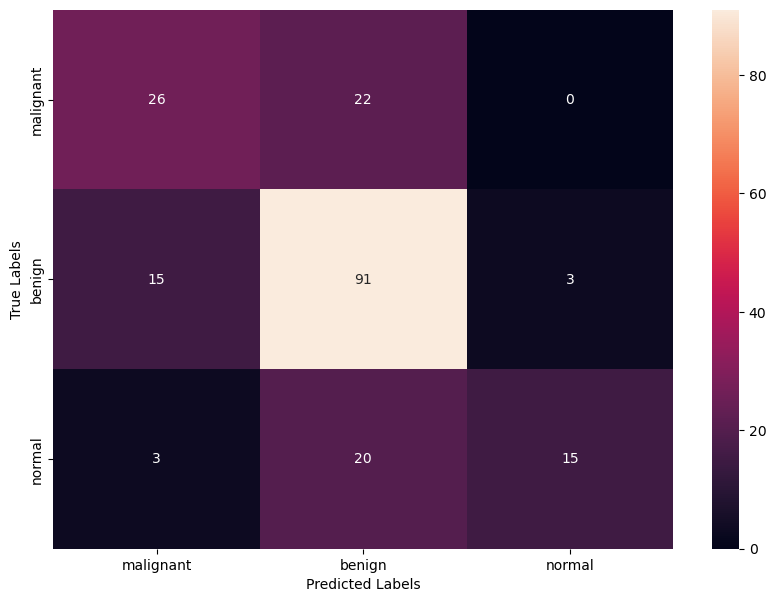

In [121]:
predicted_probs = model.predict(test_X)
predicted_labels = np.argmax(predicted_probs, axis=1)
true_labels = np.argmax(test_y, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['malignant', 'benign', 'normal'], yticklabels=['malignant', 'benign', 'normal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Exercise 12
Use Keras again to build and train a new CNN to classify the scans into three the three classes.

In [122]:
train_X, test_X, train_y, test_y = train_test_split(np_images, y, test_size=ts, shuffle=True, random_state=rs)

a. Create your CNN's architecture and compile it

In [123]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))  # 3 units for 3 classes
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                                 
 dense_30 (Dense)            (None, 128)              

b. Fit your model to the data

In [124]:
batch_size = 32
epochs = 200
history = model.fit(train_X, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_X, test_y),
                    verbose=1)

Epoch 1/200
19/19 [==============================] - 4s 140ms/step - loss: 0.9708 - accuracy: 0.5624 - val_loss: 0.9571 - val_accuracy: 0.5590
Epoch 2/200
19/19 [==============================] - 2s 124ms/step - loss: 0.9285 - accuracy: 0.5590 - val_loss: 0.9382 - val_accuracy: 0.5692
Epoch 3/200
19/19 [==============================] - 2s 123ms/step - loss: 0.8909 - accuracy: 0.6068 - val_loss: 0.9410 - val_accuracy: 0.5744
Epoch 4/200
19/19 [==============================] - 2s 125ms/step - loss: 0.8697 - accuracy: 0.6308 - val_loss: 0.9154 - val_accuracy: 0.5846
Epoch 5/200
19/19 [==============================] - 2s 123ms/step - loss: 0.8297 - accuracy: 0.6274 - val_loss: 0.8841 - val_accuracy: 0.6359
Epoch 6/200
19/19 [==============================] - 2s 115ms/step - loss: 0.8189 - accuracy: 0.6615 - val_loss: 0.8655 - val_accuracy: 0.6410
Epoch 7/200
19/19 [==============================] - 2s 106ms/step - loss: 0.7942 - accuracy: 0.6547 - val_loss: 0.8596 - val_accuracy: 0.6154

Epoch 58/200
19/19 [==============================] - 2s 110ms/step - loss: 0.2091 - accuracy: 0.9453 - val_loss: 0.8038 - val_accuracy: 0.7077
Epoch 59/200
19/19 [==============================] - 2s 108ms/step - loss: 0.2007 - accuracy: 0.9419 - val_loss: 0.8545 - val_accuracy: 0.6974
Epoch 60/200
19/19 [==============================] - 2s 100ms/step - loss: 0.1862 - accuracy: 0.9624 - val_loss: 0.7791 - val_accuracy: 0.7026
Epoch 61/200
19/19 [==============================] - 2s 109ms/step - loss: 0.1788 - accuracy: 0.9624 - val_loss: 0.7874 - val_accuracy: 0.7231
Epoch 62/200
19/19 [==============================] - 2s 128ms/step - loss: 0.1707 - accuracy: 0.9658 - val_loss: 0.8047 - val_accuracy: 0.6872
Epoch 63/200
19/19 [==============================] - 2s 129ms/step - loss: 0.1611 - accuracy: 0.9761 - val_loss: 0.8350 - val_accuracy: 0.6769
Epoch 64/200
19/19 [==============================] - 2s 128ms/step - loss: 0.1533 - accuracy: 0.9744 - val_loss: 0.8072 - val_accuracy:

Epoch 115/200
19/19 [==============================] - 2s 115ms/step - loss: 0.0288 - accuracy: 0.9983 - val_loss: 1.0729 - val_accuracy: 0.6718
Epoch 116/200
19/19 [==============================] - 2s 106ms/step - loss: 0.0314 - accuracy: 0.9949 - val_loss: 1.0513 - val_accuracy: 0.6872
Epoch 117/200
19/19 [==============================] - 2s 104ms/step - loss: 0.0296 - accuracy: 0.9983 - val_loss: 1.0840 - val_accuracy: 0.6769
Epoch 118/200
19/19 [==============================] - 2s 108ms/step - loss: 0.0308 - accuracy: 0.9966 - val_loss: 1.1323 - val_accuracy: 0.7128
Epoch 119/200
19/19 [==============================] - 2s 124ms/step - loss: 0.0301 - accuracy: 0.9966 - val_loss: 1.1400 - val_accuracy: 0.7538
Epoch 120/200
19/19 [==============================] - 2s 125ms/step - loss: 0.0347 - accuracy: 0.9932 - val_loss: 1.0639 - val_accuracy: 0.6821
Epoch 121/200
19/19 [==============================] - 2s 124ms/step - loss: 0.0246 - accuracy: 0.9966 - val_loss: 1.0817 - val_ac

19/19 [==============================] - 2s 125ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 1.2704 - val_accuracy: 0.6974
Epoch 172/200
19/19 [==============================] - 2s 124ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.2965 - val_accuracy: 0.6872
Epoch 173/200
19/19 [==============================] - 2s 122ms/step - loss: 0.0133 - accuracy: 0.9983 - val_loss: 1.3652 - val_accuracy: 0.7026
Epoch 174/200
19/19 [==============================] - 2s 116ms/step - loss: 0.0119 - accuracy: 0.9983 - val_loss: 1.4007 - val_accuracy: 0.6974
Epoch 175/200
19/19 [==============================] - 2s 106ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 1.3386 - val_accuracy: 0.6615
Epoch 176/200
19/19 [==============================] - 2s 106ms/step - loss: 0.0142 - accuracy: 0.9983 - val_loss: 1.3496 - val_accuracy: 0.6615
Epoch 177/200
19/19 [==============================] - 2s 106ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 1.3541 - val_accuracy: 0.6923

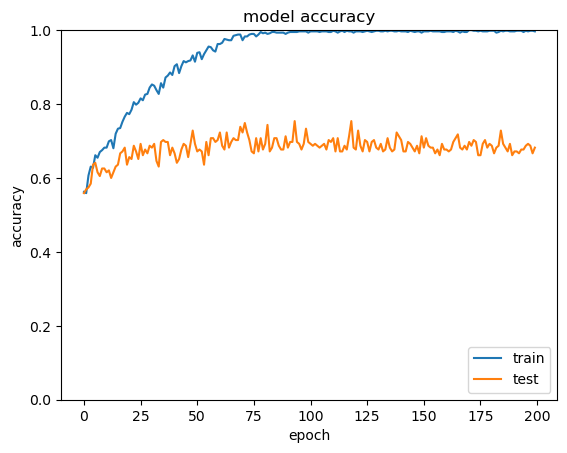

In [125]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

c. Check the performance of your model

In [126]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
print(f"Accuracy of the model on the train set is {train_accuracy * 100:.2f} %")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Accuracy of the model on the test set is {test_accuracy * 100:.2f} %")


Accuracy of the model on the train set is 100.00 %
Accuracy of the model on the test set is 68.21 %


d. Create a confusion matrix to inspect the model's output

7/7 [==============================] - 0s 27ms/step


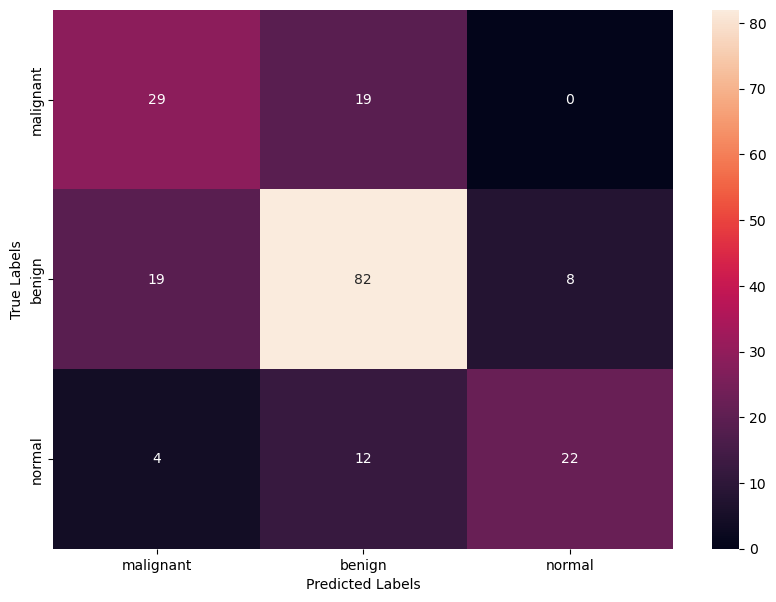

In [127]:
predicted_probs = model.predict(test_X)
predicted_labels = np.argmax(predicted_probs, axis=1)
true_labels = np.argmax(test_y, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['malignant', 'benign', 'normal'], yticklabels=['malignant', 'benign', 'normal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Optional Exercise
Both model for multiclassification overfit. This can be caused by the high complexity of the networks that we have used, it could also be due to the low number of training examples we have (around 600 used for training+ an imbalanced dataset).

Refer to this data augmentation technique suggested by Keras [Image Data Generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), and check whether it can help bridge the gap between the accuracy in training and the accuracy of the test set.


In [128]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,   
    zoom_range=0.2,         
    shear_range=0.2)        

train_X = train_X.reshape(train_X.shape[0], 64, 64, 1)
test_X = test_X.reshape(test_X.shape[0], 64, 64, 1)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


datagen.fit(train_X)


steps_per_epoch = len(train_X) / batch_size
history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(test_X, test_y),
    verbose=1)

Epoch 1/200
18/18 [==============================] - 5s 162ms/step - loss: 0.9841 - accuracy: 0.5590 - val_loss: 1.0118 - val_accuracy: 0.5641
Epoch 2/200
18/18 [==============================] - 2s 130ms/step - loss: 0.9595 - accuracy: 0.5641 - val_loss: 0.9614 - val_accuracy: 0.5590
Epoch 3/200
18/18 [==============================] - 2s 132ms/step - loss: 0.9455 - accuracy: 0.5709 - val_loss: 0.9515 - val_accuracy: 0.5641
Epoch 4/200
18/18 [==============================] - 3s 144ms/step - loss: 0.9388 - accuracy: 0.5726 - val_loss: 0.9416 - val_accuracy: 0.5692
Epoch 5/200
18/18 [==============================] - 3s 152ms/step - loss: 0.9267 - accuracy: 0.5880 - val_loss: 0.9340 - val_accuracy: 0.5846
Epoch 6/200
18/18 [==============================] - 3s 152ms/step - loss: 0.9159 - accuracy: 0.5863 - val_loss: 0.9265 - val_accuracy: 0.6103
Epoch 7/200
18/18 [==============================] - 3s 142ms/step - loss: 0.9206 - accuracy: 0.5863 - val_loss: 0.9180 - val_accuracy: 0.5641

Epoch 58/200
18/18 [==============================] - 2s 134ms/step - loss: 0.7501 - accuracy: 0.6786 - val_loss: 0.8271 - val_accuracy: 0.6462
Epoch 59/200
18/18 [==============================] - 2s 132ms/step - loss: 0.7580 - accuracy: 0.6667 - val_loss: 0.9504 - val_accuracy: 0.5590
Epoch 60/200
18/18 [==============================] - 3s 153ms/step - loss: 0.7470 - accuracy: 0.6786 - val_loss: 0.8655 - val_accuracy: 0.6256
Epoch 61/200
18/18 [==============================] - 3s 154ms/step - loss: 0.7485 - accuracy: 0.6821 - val_loss: 0.8341 - val_accuracy: 0.6410
Epoch 62/200
18/18 [==============================] - 3s 155ms/step - loss: 0.7247 - accuracy: 0.6991 - val_loss: 0.8545 - val_accuracy: 0.6410
Epoch 63/200
18/18 [==============================] - 3s 134ms/step - loss: 0.7389 - accuracy: 0.6821 - val_loss: 0.8712 - val_accuracy: 0.6256
Epoch 64/200
18/18 [==============================] - 2s 130ms/step - loss: 0.7365 - accuracy: 0.6923 - val_loss: 0.8453 - val_accuracy:

Epoch 115/200
18/18 [==============================] - 3s 167ms/step - loss: 0.7004 - accuracy: 0.7060 - val_loss: 0.8270 - val_accuracy: 0.6410
Epoch 116/200
18/18 [==============================] - 3s 154ms/step - loss: 0.6759 - accuracy: 0.7094 - val_loss: 0.7724 - val_accuracy: 0.6821
Epoch 117/200
18/18 [==============================] - 2s 131ms/step - loss: 0.6669 - accuracy: 0.7094 - val_loss: 0.7697 - val_accuracy: 0.6718
Epoch 118/200
18/18 [==============================] - 2s 128ms/step - loss: 0.6915 - accuracy: 0.7060 - val_loss: 0.8440 - val_accuracy: 0.6615
Epoch 119/200
18/18 [==============================] - 3s 141ms/step - loss: 0.6650 - accuracy: 0.7214 - val_loss: 0.8415 - val_accuracy: 0.6462
Epoch 120/200
18/18 [==============================] - 3s 157ms/step - loss: 0.6549 - accuracy: 0.7145 - val_loss: 0.8418 - val_accuracy: 0.6615
Epoch 121/200
18/18 [==============================] - 3s 157ms/step - loss: 0.6671 - accuracy: 0.7282 - val_loss: 0.7766 - val_ac

18/18 [==============================] - 3s 141ms/step - loss: 0.6243 - accuracy: 0.7350 - val_loss: 0.9225 - val_accuracy: 0.6410
Epoch 172/200
18/18 [==============================] - 2s 136ms/step - loss: 0.6683 - accuracy: 0.7231 - val_loss: 0.8042 - val_accuracy: 0.6667
Epoch 173/200
18/18 [==============================] - 2s 132ms/step - loss: 0.6147 - accuracy: 0.7350 - val_loss: 0.7564 - val_accuracy: 0.7077
Epoch 174/200
18/18 [==============================] - 3s 154ms/step - loss: 0.6160 - accuracy: 0.7470 - val_loss: 0.7390 - val_accuracy: 0.7077
Epoch 175/200
18/18 [==============================] - 3s 158ms/step - loss: 0.6418 - accuracy: 0.7299 - val_loss: 0.7401 - val_accuracy: 0.7077
Epoch 176/200
18/18 [==============================] - 3s 161ms/step - loss: 0.6382 - accuracy: 0.7299 - val_loss: 0.6895 - val_accuracy: 0.7128
Epoch 177/200
18/18 [==============================] - 3s 140ms/step - loss: 0.6748 - accuracy: 0.7128 - val_loss: 0.7219 - val_accuracy: 0.7077

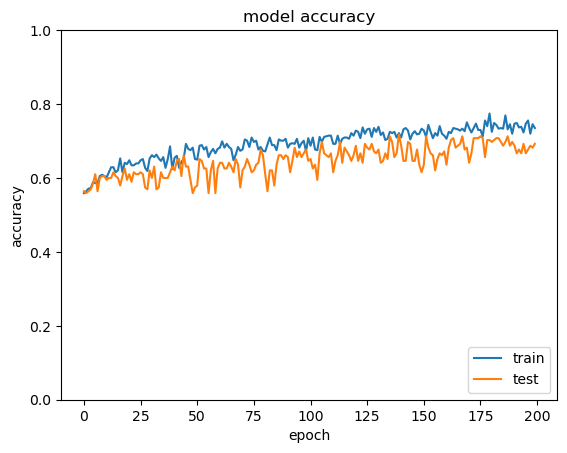

In [129]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [130]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
print(f"Accuracy of the model on the train set is {train_accuracy * 100:.2f} %")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Accuracy of the model on the test set is {test_accuracy * 100:.2f} %")

Accuracy of the model on the train set is 71.45 %
Accuracy of the model on the test set is 69.23 %


### Regular Level
In this part, we wish to implement our own deep learning network for binary classification.
### Exercise 13
To test the functions, let's use a network of the dimensions [64X64, 128,64,1]

We'll first write the function initialize(network_dims), which will initialize the weights and biases of our network.

a. Copy your **y** vector of binary classification (not the one hot-encoded matrix)

In [131]:
y = [0 if label_name == 'malignant' else 1 for label_name in label]
y = np.array(y)

In [132]:
train_X, test_X, train_y, test_y = train_test_split(np_images_flattened, y, test_size=ts, shuffle=True, random_state=rs)

In [133]:
def initialize(network_dims):
    params = {}
    L = len(network_dims)
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(network_dims[l], network_dims[l - 1])
        params['b' + str(l)] = np.random.randn(network_dims[l], 1)

    return params

In [134]:
params=initialize([train_X.shape[1], 128,64, 1])

In [135]:
print('shape of W1', params['W1'].shape)
print('shape of b1', params['b1'].shape)
print('shape of W2', params['W2'].shape)
print('shape of b2', params['b2'].shape)
print('shape of W3', params['W3'].shape)
print('shape of b3', params['b3'].shape)

shape of W1 (128, 4096)
shape of b1 (128, 1)
shape of W2 (64, 128)
shape of b2 (64, 1)
shape of W3 (1, 64)
shape of b3 (1, 1)


You are now requested to implement the forward_pass(X, params), which takes your training set X as input and returns the activations of the hidden and final layer.
Your function should implement the following functions:

$$Z^{[l]}=W^{[l]}.A^{[l-1]}+b^{[l]}$$
$$A^{[l]}=\sigma Z^{[l]}$$

You of course need to iterate over the layers of your model (hidden and final/output layer).


In [136]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def forward_pass(X, params):
    # Number of layers
    L = len(params) // 2
    activations = {}
    A = X
    for l in range(1, L+1):
        Z = np.dot(params['W' + str(l)], A) + params['b' + str(l)]
        A = sigmoid(Z)
        activations['A' + str(l)] = A
        
    return activations


In [137]:
#recall that X in our scenario is of shape (nf, ne)
train_X=train_X.T

In [138]:
activations=forward_pass(train_X, params)

In [139]:
print("The shape of the activation of the first layer",activations['A1'].shape)
print("The shape of the activation of the second layer",activations['A2'].shape)
print("The shape of the activation of the output layer",activations['A3'].shape)

The shape of the activation of the first layer (128, 585)
The shape of the activation of the second layer (64, 585)
The shape of the activation of the output layer (1, 585)


### Exercise 14
We get now to implementing our gradient descent.

Write a function gradient_descent(params, activations, y, lr), which inputs your parameters, the activations of your forward_pass, your ground truth vector y and your learning_rate lr. 

The function needs to implement the following equations:

$$dZ^{[fl]}=A^{[fl]}-y$$
$$dZ^{[l-1]}=W^{[l]}T .dZ^{[l]} * A^{[l-1]}(1-A^{[l-1]})$$
$$dW^{[l]}=\frac {1}{ne} (dZ^{[l]}.A^{[l-1]}T)$$
$$dW^{[l]}=\frac {1}{ne} \sum dZ^{[l]} $$
$$W=W-\alpha dW$$

$$W=b-\alpha db$$


In [140]:
def gradient_descent(activations, params, y, lr):
    L = len(params) // 2  
    m = y.shape[0]
    grads = {}
    
    # Compute dZ for the final layer
    dZ = activations['A' + str(L)] - y
    for l in range(L, 0, -1):
        # 'A0' is the input layer (train_X)
        A_prev = activations['A' + str(l - 1)] if l != 1 else train_X
        
        # Compute dW and db for the current layer
        grads["dW" + str(l)] = (1/m) * np.dot(dZ, A_prev.T)
        grads["db" + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        # Update parameters
        params["W" + str(l)] -= lr * grads["dW" + str(l)]
        params["b" + str(l)] -= lr * grads["db" + str(l)]
        
        # Compute dZ for the previous layer if not the input layer
        if l > 1:
            dZ = np.dot(params["W" + str(l)].T, dZ) * A_prev * (1 - A_prev)
    
    return params


In [141]:
params=gradient_descent(activations, params, train_y, lr=0.5)

In [142]:
print('shape of W1', params['W1'].shape)
print('shape of b1', params['b1'].shape)
print('shape of W2', params['W2'].shape)
print('shape of b2', params['b2'].shape)
print('shape of W3', params['W3'].shape)
print('shape of b3', params['b3'].shape)

shape of W1 (128, 4096)
shape of b1 (128, 1)
shape of W2 (64, 128)
shape of b2 (64, 1)
shape of W3 (1, 64)
shape of b3 (1, 1)


### Exercise 15
Now we can implement our dnn model in 3 simple steps
1. initialize the matrices W and the bias vectors b
2. repeat until number of iterations is reached <br>
    2.1. get your matrices of activations<br>
    2.2. update the weights W and biases b using gradient descent<br>
3. return the final matrices for  W and bias vectors b

dnn(X, y, network_dims, lr, iters), takes the matrix X as an input, the vector of true labels y, network dimensions, a learning rate, and the number of iterations iters. The function returns the learned parameters of the model, namely W and b.


In [143]:
def dnn(X, y, network_dims, lr, iters):
    params = initialize(network_dims)
    for i in range(iters):
        activations = forward_pass(X, params)
        params = gradient_descent(activations, params, y, lr)
        
    return params

In [144]:
params=dnn(train_X, train_y, network_dims = [train_X.shape[0], 64, 32,1 ], lr = 0.75, iters = 50)

In [145]:
def predict(X, params):
    activations = forward_pass(X, params)
    L = len(params) // 2
    Af = activations['A' + str(L)]
    return  1*(Af>=0.5)

In [146]:
predictions=predict(test_X.T, params)

In [147]:
print("Accuracy on our test set is", accuracy_score(test_y.flatten(), predictions.flatten())*100, "%")

Accuracy on our test set is 75.38461538461539 %


#### Quite a good result actually.

## Advanced Level
We said in the lecture that a sigmoid activated neurone predicts values between 0 and 1, making it adequate for binary classification.

We also said that a softmax activation function is suitable for multiclassification.
To change our code above and make it capable of solving multiclassification problems, we need to implement the softmax function.
We also said that the log_loss isn't useful in this case, we will instead use cross entropy loss.

We also said that **dZL** (L for final layer) remains the same as before.

Your task is to modify the code you implemented above to handle the same multiclassification problem you handled with Keras.

We are not interested in a completely new implementation, we expect that you will modify one of your functions above and adapt the code to handle the new type of classification (multiclass).

In [ ]:
def initialize(network_dims):
    np.random.seed(42)
    params = {}
    L = len(network_dims)
    
    for l in range(1, L):
        params["W" + str(l)] = np.random.randn(network_dims[l], network_dims[l-1]) * 0.01
        params["b" + str(l)] = np.zeros((network_dims[l], 1))
        
    return params

In [ ]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

In [ ]:
def forward_pass_multiclassification(X, params):
    L = len(params) // 2
    activations = {}
    A = X
    for l in range(1, L):
        Z = np.dot(params['W' + str(l)], A) + params['b' + str(l)]
        A = sigmoid(Z)
        activations['A' + str(l)] = A
    
    Z = np.dot(params['W' + str(L)], A) + params['b' + str(L)]
    A = softmax(Z)
    activations['A' + str(L)] = A
    
    return activations

In [ ]:
def gradient_descent_multiclass(activations, params, y, lr):
    L = len(params) // 2  
    m = y.shape[1]
    grads = {}
    
    # Compute dZ for the final layer
    dZ = activations['A' + str(L)] - y
    for l in range(L, 0, -1):
        A_prev = activations['A' + str(l - 1)] if l != 1 else train_X
        
        grads["dW" + str(l)] = (1/m) * np.dot(dZ, A_prev.T)
        grads["db" + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        params["W" + str(l)] -= lr * grads["dW" + str(l)]
        params["b" + str(l)] -= lr * grads["db" + str(l)]
        
        if l > 1:
            dZ = np.dot(params["W" + str(l)].T, dZ) * A_prev * (1 - A_prev)
    
    return params


In [ ]:
def dnn_2(X, y, network_dims, lr, iters):
    params = initialize(network_dims)
    for i in range(iters):
        activations = forward_pass_multiclassification(X, params)
        params = gradient_descent_multiclass(activations, params, y, lr)
        
    return params


In [ ]:
# Encoding test_y (Assuming it has the same structure as 'label')
test_y_encoded = [0 if label_name == 'malignant' else 1 if label_name == 'benign' else 2 for label_name in test_y]
test_y_encoded = np.array(test_y_encoded)
test_y_encoded = to_categorical(test_y_encoded, num_classes=3).T

In [ ]:
# Check shape of input data and labels before training:
print(train_X.T.shape, y_encoded.T.shape)

params = dnn_2(train_X.T, y_encoded.T, network_dims=[train_X.shape[1], 64, 4, 3], lr=0.05, iters=100)

In [ ]:
def predict(X, params):
    activations = forward_pass_multiclassification(X, params)
    C = len(params) // 2
    Af = activations['A' + str(C)]
    return np.argmax(Af, axis=0) 

In [ ]:
predictions=predict(test_X.T, params)
test_y_class_numbers = np.argmax(test_y_encoded, axis=1)
# Check the shape of predictions and test labels:
print(len(predictions), len(test_y_class_numbers))


In [ ]:
accuracy = accuracy_score(test_y_class_numbers, predictions) * 100
print(f"Accuracy on our test set is {accuracy:.2f}%")